In [2]:
%matplotlib inline
import math
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

mapperAccuracyFile = "mapperAccuracy.txt"
kmerAccuracyPrefix = "kmerAccuracy"
timeMapperFile = "timerMapper.txt"
timeIndexFile= "./dummy_reads/timeMapIndex.txt"
kmerSize = [21, 25, 27, 31]
def addBreakClips(ax1,ax2):
    """ Code to add diagonal slashes to truncated y-axes.
    copied from http://matplotlib.org/examples/pylab_examples/broken_axis.html"""
    
    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='r', clip_on=False)
    ax1.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
    #ax1.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
    #ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


###Read Accuracy into a dictionary

In [2]:
def readValue(fileName, flag = ''):
    mapValueDict = {}
    with open(fileName, 'r') as fileHandle:
        for line in fileHandle:
            #get name of mapper
            if flag == 'kmerFile':
                mapperName = len(mapValueDict)+1
            else:
                mapperName = line.strip().split("/")[-1].replace('.sam','')   

            #use temporary dictionary
            valueDict = {}

            #get total no. of reads
            line = fileHandle.next().strip()
            valueDict['reads'] = int(line.split("=")[-1])

            #get # of reads Aligned
            line = fileHandle.next().strip()
            valueDict['align'] = int(line.split("=")[-1])

            #get # of True positive
            line = fileHandle.next().strip()
            valueDict['tp'] = int(line.split("=")[-1])

            #get # of False positive
            line = fileHandle.next().strip()
            valueDict['fp'] = int(line.split("=")[-1])

            #get # of False negative
            line = fileHandle.next().strip()
            valueDict['fn'] = int(line.split("=")[-1])

            #get precision
            line = fileHandle.next().strip()
            valueDict['pre'] = float(line.split("=")[-1].replace('%',''))

            #get recall
            line = fileHandle.next().strip()
            valueDict['recall'] = float(line.split("=")[-1].replace('%',''))

            #ignore true positve % since same as precision
            line = fileHandle.next().strip()

            #get FDR %
            line = fileHandle.next().strip()
            valueDict['fdr'] = float(line.split("=")[-1].replace('%',''))

            #get f1 %
            line = fileHandle.next().strip()
            valueDict['f1'] = float(line.split("=")[-1].replace('%',''))

            #get avg hits per read

            line = fileHandle.next().strip()
            valueDict['hpr'] = float(line.split("=")[-1].replace('%',''))

            mapValueDict[mapperName] = valueDict

        return mapValueDict

###Mapper-Accuracy plot

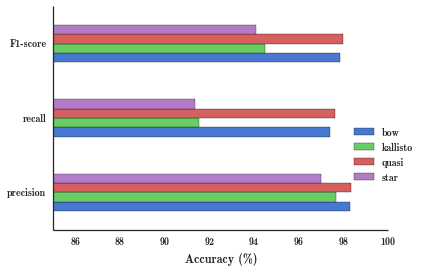

In [178]:
sns.set_style("white")

mapValueDict = readValue(mapperAccuracyFile)
mvd = pd.DataFrame(mapValueDict)

mvd.loc['precision'] = mvd.loc['pre']
mvd.loc['F1-score'] = mvd.loc['f1']
mvd.loc['FDR'] = mvd.loc['fdr']
mvd.loc['hits per read'] = mvd.loc['hpr']

mvd.loc[['precision', 'recall', 'F1-score']].plot(kind='barh', grid=False).legend(bbox_to_anchor=(1.1, 0.5))
plt.xlim(85,100)
sns.despine()
plt.xlabel('Accuracy (%)', fontsize='large')
plt.savefig('./dummy_reads/mapping_scorebenchmark.pdf',bbox_inches='tight', pad_inches=0)

In [179]:
mvd

,bow,kallisto,quasi,star
align,47579567.00,44774502.00,47677356.00,44711604.00
f1,97.86,94.50,97.98,94.10
fdr,1.69,2.33,1.65,2.98
fn,1241778.00,4046843.00,1143989.00,4109741.00
fp,805965.00,1042167.00,785845.00,1330181.00
hpr,0.00,5.30,4.30,3.80
pre,98.31,97.67,98.35,97.02
reads,48821345.00,48821345.00,48821345.00,48821345.00
recall,97.41,91.53,97.62,91.35
tp,46773603.00,43732336.00,46891512.00,43381424.00


In [180]:
fp = open('./dummy_reads/score_table.tex','w')
fp.write(str(mvd.to_latex()))

In [181]:
mvd2 = mvd.drop(['f1','fdr','pre','reads', 'hpr', 'tp', 'fp', 'fn'])
print (mvd2.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &          bow &     kallisto &        quasi &         star \\
\midrule
align         &  47579567.00 &  44774502.00 &  47677356.00 &  44711604.00 \\
recall        &        97.41 &        91.53 &        97.62 &        91.35 \\
precision     &        98.31 &        97.67 &        98.35 &        97.02 \\
F1-score      &        97.86 &        94.50 &        97.98 &        94.10 \\
FDR           &         1.69 &         2.33 &         1.65 &         2.98 \\
hits per read &         0.00 &         5.30 &         4.30 &         3.80 \\
\bottomrule
\end{tabular}



###kmer-Accuracy plot

#F1-score

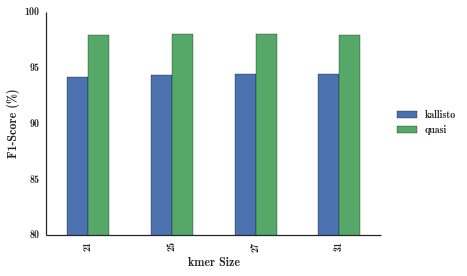

In [52]:
sns.set_style("white")

kmerValueDict = {}
for kmer in kmerSize:
    kmerValueDict[kmer] = readValue(kmerAccuracyPrefix+str(kmer)+".txt", 'kmerFile')

plotDict = {'quasi' : {}, 'kallisto' : {}}
kmer = []

for kmer in kmerSize:
    for id in [1, 2]:
        if id == 1:
            plotDict['quasi'][kmer] = kmerValueDict[kmer][id]['f1']
        else:
            plotDict['kallisto'][kmer] =  kmerValueDict[kmer][id]['f1']
       
mvd = pd.DataFrame(plotDict)
mvd.loc[[21, 25, 27, 31]].plot(kind='bar', grid=False).legend(bbox_to_anchor=(1.25, 0.6))
plt.ylim(80,100)
sns.despine()
plt.xlabel('kmer Size', fontsize='large')
plt.ylabel('F1-Score (%)', fontsize='large')
plt.savefig('./dummy_reads/f1.pdf',bbox_inches='tight', pad_inches=0)

In [15]:
mvd

,kallisto,quasi
21,94.20,97.99
25,94.36,98.02
27,94.42,98.02
31,94.50,97.98


#hits/read

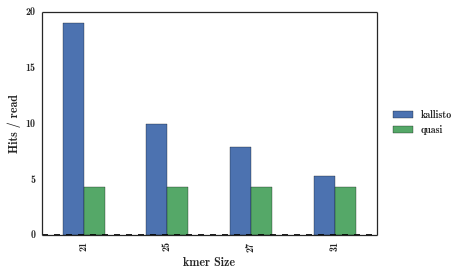

In [53]:
sns.set_style("white")

kmerValueDict = {}
for kmer in kmerSize:
    kmerValueDict[kmer] = readValue(kmerAccuracyPrefix+str(kmer)+".txt", 'kmerFile')

plotDict = {'quasi' : {}, 'kallisto' : {}}
kmer = []

for kmer in kmerSize:
    for id in [1, 2]:
        if id == 1:
            plotDict['quasi'][kmer] = kmerValueDict[kmer][id]['hpr']
        else:
            plotDict['kallisto'][kmer] =  kmerValueDict[kmer][id]['hpr']
       
mvd = pd.DataFrame(plotDict)
mvd.loc[[21, 25, 27, 31]].plot(kind='bar', grid=False).legend(bbox_to_anchor=(1.25, 0.6))
plt.xlabel('kmer Size', fontsize='large')
plt.ylabel('Hits / read', fontsize='large')
plt.savefig('./dummy_reads/heats_read.pdf',bbox_inches='tight', pad_inches=0)

#Recall

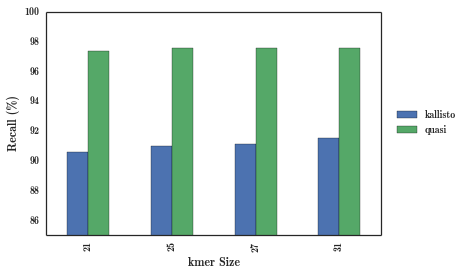

In [54]:
sns.set_style("white")

kmerValueDict = {}
for kmer in kmerSize:
    kmerValueDict[kmer] = readValue(kmerAccuracyPrefix+str(kmer)+".txt", 'kmerFile')

plotDict = {'quasi' : {}, 'kallisto' : {}}
kmer = []

for kmer in kmerSize:
    for id in [1, 2]:
        if id == 1:
            plotDict['quasi'][kmer] = kmerValueDict[kmer][id]['recall']
        else:
            plotDict['kallisto'][kmer] =  kmerValueDict[kmer][id]['recall']
       
mvd = pd.DataFrame(plotDict)
mvd.loc[[21, 25, 27, 31]].plot(kind='bar', grid=False).x
plt.ylim(85,100)
plt.xlabel('kmer Size', fontsize='large')
plt.ylabel('Recall (%)', fontsize='large')
plt.savefig('./dummy_reads/recall.pdf',bbox_inches='tight', pad_inches=0)

In [18]:
mvd

,kallisto,quasi
21,90.63,97.38
25,91.01,97.60
27,91.15,97.57
31,91.53,97.62


#Time-Mapper Plot

In [3]:
timeDict = {}
memDict = {}
timeIndDict = {}
from __future__ import print_function
with open(timeMapperFile, 'r') as fileHandle:
    for line in fileHandle:
        mapperName = line.strip().replace('_48M','')
        line = fileHandle.next().strip().split(',')
        if len(line[0].split(':')) == 2:
            timeDict[mapperName] = "{0:.2f}".format(float(line[0].split(':')[0]) + (float(line[0].split(':')[1]) / 60))
        elif len(line[0].split(':')) == 3:
            timeDict[mapperName] = "{0:.2f}".format(float(line[0].split(':')[0])*60 + (float(line[0].split(':')[1])) + (float(line[0].split(':')[1]) / 60))
        memDict[mapperName] = line[1]
with open(timeIndexFile, 'r') as fileHandle:
    for line in fileHandle:
        mapperName = line.strip().replace('_48M','load')
        line = fileHandle.next().strip().split(',')
        timeIndDict[mapperName] = "{0:.2f}".format(float(line[0].split(':')[0]) + (float(line[0].split(':')[1]) / 60))
print (timeDict)
print (memDict)
print (timeIndDict)

{'star_8': '20.26', 'quasi_10': '2.59', 'bowtie2_10': '421.02', 'star_2': '66.10', 'star_1': '132.20', 'star_4': '33.32', 'quasi_8': '3.40', 'star_10': '16.77', 'quasi_1': '10.37', 'quasi_2': '6.27', 'quasi_4': '4.39'}
{'star_8': ' 4708952', 'quasi_10': ' 5201588', 'bowtie2_10': ' 922404', 'star_2': ' 3773536', 'star_1': ' 3630760', 'star_4': ' 4086268', 'quasi_8': ' 5194372', 'star_10': ' 5023836', 'quasi_1': ' 5170608', 'quasi_2': ' 5173596', 'quasi_4': ' 5181304'}
{'quasiload_1': '0.11', 'quasiload_8': '0.10', 'quasiload_2': '0.10', 'quasiload_10': '0.10', 'quasiload_4': '0.10'}


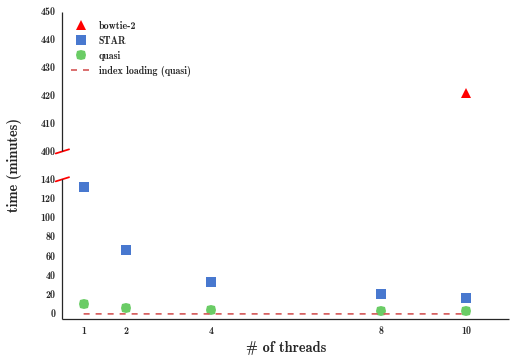

In [7]:
#Time/Thread Graph
sns.set_style("white")
threads = [1, 2, 4, 8, 10]

#axes = plt.gca()
fig,(ax2,ax1) = plt.subplots(2, 1, sharex=True)
ax1.set_xlim([0.5, 11])
ax1.set_ylim([-5, 140])
ax2.set_ylim([400, 450])
plt.ylabel('time (minutes)', fontsize= 'x-large' )
plt.xlabel('# of threads', fontsize= 'x-large' )

quasiVal = [timeDict['quasi_1'], timeDict['quasi_2'], timeDict['quasi_4'], timeDict['quasi_8'], timeDict['quasi_10']]
quasiLoad = [timeIndDict['quasiload_1'], timeIndDict['quasiload_2'], timeIndDict['quasiload_4'], timeIndDict['quasiload_8'], timeIndDict['quasiload_10']]
starVal = [timeDict['star_1'], timeDict['star_2'], timeDict['star_4'], timeDict['star_8'], timeDict['star_10']]

sns.set_palette('muted')


ms = 10
bow, = ax2.plot(threads[-1], timeDict['bowtie2_10'], 'r^', markersize=ms)
STAR, = ax1.plot(threads, starVal, 's', markersize=ms)
quasi = ax1.plot(threads, quasiVal, 'o', markersize=ms)
quasiload = ax1.plot(threads, quasiLoad, '--', markersize=ms)
plt.xticks(threads, threads)
sns.despine()
ax2.spines['bottom'].set_visible(False)
addBreakClips(ax2, ax1)

x0, y0 = ax1.yaxis.label.get_position()
ax1.yaxis.set_label_coords(x0-0.09, y0+0.6)

ax2.legend([bow, STAR, quasi[0], quasiload[0]], ["bowtie-2", "STAR", "quasi", "index loading (quasi)"], loc = 2)
plt.savefig('./dummy_reads/timeBench.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

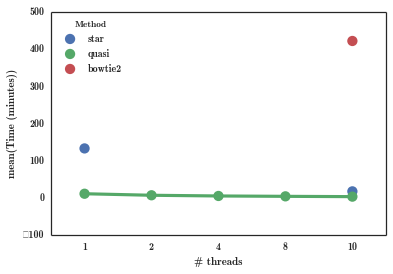

In [90]:
dat = [(n.split('_')[0], float(v), int(n.split('_')[-1])) for n,v in timeDict.iteritems()]
D = pd.DataFrame(dat)
D.columns = ['Method', 'Time (minutes)', '# threads']
sns.pointplot(x="# threads", y="Time (minutes)", hue='Method', data=D.sort("# threads"))

In [11]:
timeDict

{'bowtie2_10': '421.02',
 'quasi_1': '10.37',
 'quasi_10': '2.59',
 'quasi_2': '6.27',
 'quasi_4': '4.39',
 'quasi_8': '3.40',
 'star_1': '132.20',
 'star_10': '16.77'}

###Real Data Venn plot

In [43]:
fileName = "venStats.txt"
cap = []

with open(fileName, 'r') as fileHandle:
    data = fileHandle.readlines()
n1 = int(data[7].strip()[-8:])
n2 = int(data[8].strip()[-8:])
n3 = int(data[9].strip()[-8:])
n4 = int(data[10].strip()[-8:])

cap.append(int(data[14].strip()[-8:]))
n12 = int(data[36].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[38].strip()[-8:]))
n13 = int(data[59].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[61].strip()[-8:]))
n14 = int(data[82].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[84].strip()[-8:]))
n23 = int(data[105].strip().replace("(", '').replace(")", '').split(',')[-1])
    
cap.append(int(data[107].strip()[-8:]))
n24 = int(data[128].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[130].strip()[-8:]))
n34 = int(data[150].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[153].strip()[-8:]))
n123 = int(data[174].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[177].strip()[-8:]))
n124 = int(data[197].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[200].strip()[-8:]))
n134 = int(data[220].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[223].strip()[-8:]))
n234 = int(data[243].strip().replace("(", '').replace(")", '').split(',')[-1])

cap.append(int(data[246].strip()[-8:]))
n1234 = int(data[266].strip().replace("(", '').replace(")", '').split(',')[-1])

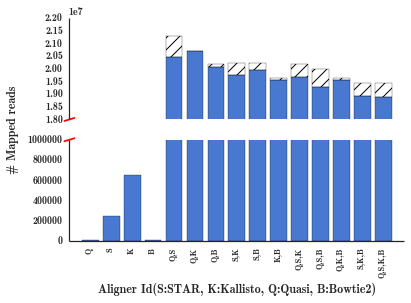

In [203]:
r9 = n1234

r5  =  n123 - r9
r8  =  n234 - r9
r10 =  n124 - r9
r13 =  n134 - r9

r2  =   n13 - (r5 + r9 + r13)
r11 =   n24 - (r8 + r9 + r10)
r12 =   n34 - (r8 + r9 + r13)
r4  =   n23 - (r5 + r8 + r9)
r14 =   n14 - (r9 + r10 + r13)
r6  =   n12 - (r9 + r10 + r5)

r1  = n3 - (r2 + r4 + r5 + r8 + r9 + r12 + r13)
r3  = n1 - (r2 + r5 + r6 + r10 + r9 + r13 + r14)
r7  = n2 - (r4 + r5 + r6 + r8 + r9 + r10 + r11)
r15 = n4 - (r8 + r9 + r10 + r11 + r12 + r13 + r14)


val = [r1, r3, r7, r15, n12, n13, n14, n23, n24, n34, n123, n124, n134, n234, n1234]
errCap = [cap[id-4]-val[id] for id in range(4, 15)]

#axes = plt.gca()
fig,(ax2,ax1) = plt.subplots(2, 1, sharex=True)
plt.ylabel('# Mapped reads', fontsize= 'large' )
plt.xlabel('Aligner Id(S:STAR, K:Kallisto, Q:Quasi, B:Bowtie2)', fontsize= 'large' )
#plt.title('Venn Plot', fontsize= 'large' )

ax1.set_ylim([0, 1000000])
ax2.set_ylim([18000000, 22000000])

ax1.bar(range(15), val, align='center')
#ax2.bar(range(4, 15), errCap, bottom=val[4:15], color='r', align='center')
ax2.bar(range(15), val, align='center')
ax2.bar(range(4, 15), errCap, bottom=val[4:15], color='r', fill=False, hatch='//', align='center')
sns.despine()
ax2.spines['bottom'].set_visible(False)

addBreakClips(ax2, ax1)
plt.xticks(range(15), ['Q', 'S', 'K', 'B', 'Q,S', 'Q,K', 'Q,B', 'S,K', 'S,B', 'K,B', 'Q,S,K', 'Q,S,B', 'Q,K,B', 'S,K,B', 'Q,S,K,B' ], size='small', rotation=90)
ax1.set_xlim([-1, 15])
x0, y0 = ax1.yaxis.label.get_position()
ax1.yaxis.set_label_coords(x0-0.15, y0+0.6)
plt.savefig('./dummy_reads/concordance.pdf',bbox_inches='tight', pad_inches=0)

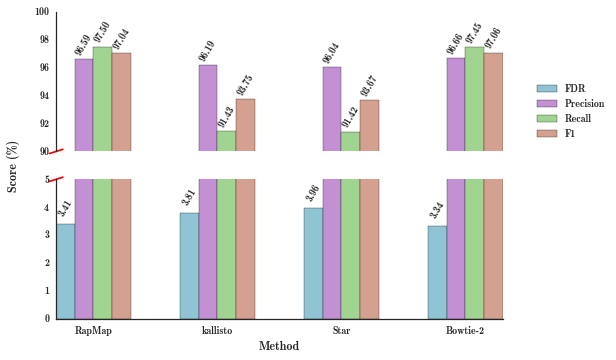

In [74]:
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("white")

def autolabel(rects, ax):
    for rect in rects:
    # attach some text labels
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+0.2,
                '%.2f' % float(height),
                ha='center', va='bottom', rotation=60)

N = 4
# menMeans = (2, 3, 3, 4)
# womenMeans = (91, 92, 94, 93)
pre = [96.59, 	96.19, 	96.04,	96.66]
rec = [97.50,	91.43,	91.42,	97.45]
fdr = [3.41,	3.81,	3.96,	3.34]
f1 =	[97.04,	93.75,	93.67,	97.06]

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig,(ax2,ax1) = plt.subplots(2, 1, sharex=True)

ax1.set_ylim([0, 5])
ax2.set_ylim([90, 100])

autolabel(ax1.bar(ind, fdr, width, color='#90C3D4', label='FDR'), ax1)


ax1.bar(ind+width, pre, width, color='#C390D4', label='Precision')
autolabel(ax2.bar(ind+width, pre, width, color='#C390D4'), ax2)

ax1.bar(ind+(2*width), rec, width, color='#A1D490', label='Recall')
autolabel(ax2.bar(ind+(2*width), rec, width, color='#A1D490'), ax2)

ax1.bar(ind+(3*width), f1, width, color='#D4A190', label='F1')
autolabel(ax2.bar(ind+(3*width), f1, width, color='#D4A190'), ax2)

# add some
ax1.set_ylabel('Score (%)', fontsize= 'large' )
ax1.set_xlabel('Method', fontsize= 'large')

ax1.set_xticks(ind+2*width)
ax1.set_xticklabels( ('RapMap', 'kallisto', 'Star', 'Bowtie-2') )
addBreakClips(ax2, ax1)
# ax1.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

x0, y0 = ax1.yaxis.label.get_position()
ax1.yaxis.set_label_coords(x0-0.08, y0+0.6)
sns.despine()

ax2.spines['bottom'].set_visible(False)
plt.legend(bbox_to_anchor=(1.25, 1.75))

# plt.show()

plt.savefig('./dummy_reads/concordance.pdf',bbox_inches='tight', pad_inches=0)

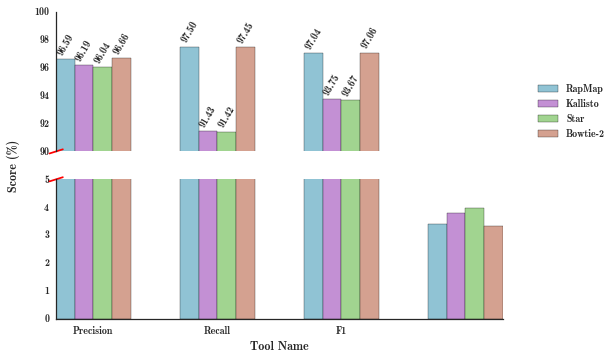

In [95]:
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("white")

def autolabel(rects, ax):
    for rect in rects:
    # attach some text labels
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+0.2,
                '%.2f' % float(height),
                ha='center', va='bottom', rotation=60)
N = 3
# menMeans = (2, 3, 3, 4)
# womenMeans = (91, 92, 94, 93)
R = [96.59, 97.50, 97.04]
K = [96.19, 91.43, 93.75]
S = [96.04, 91.42, 93.67]
B = [96.66, 97.45, 97.06]

FDR = [3.41, 3.81, 3.96, 3.34]
# pre = [96.59, 	96.19, 	96.04,	96.66]
# rec = [97.50,	91.43,	91.42,	97.45]
# fdr = [3.41,	3.81,	3.96,	3.34]
# f1 =	[97.04,	93.75,	93.67,	97.06]

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig,(ax2,ax1) = plt.subplots(2, 1, sharex=True)

ax1.set_ylim([0, 5])
ax2.set_ylim([90, 100])

ax1.bar(ind, R, width, color='#90C3D4', label='RapMap')
autolabel(ax2.bar(ind, R, width, color='#90C3D4'), ax2)


ax1.bar(ind+width, K, width, color='#C390D4', label='Kallisto')
autolabel(ax2.bar(ind+width, K, width, color='#C390D4'), ax2)

ax1.bar(ind+(2*width), S, width, color='#A1D490', label='Star')
autolabel(ax2.bar(ind+(2*width), S, width, color='#A1D490'), ax2)

ax1.bar(ind+(3*width), B, width, color='#D4A190', label='Bowtie-2')
autolabel(ax2.bar(ind+(3*width), B, width, color='#D4A190'), ax2)

ax1.bar(3, FDR[0], width, color='#90C3D4')
ax1.bar(3+width, FDR[1], width, color='#C390D4')
ax1.bar(3+(2*width), FDR[2], width, color='#A1D490')
ax1.bar(3+(3*width), FDR[3], width, color='#D4A190')

# add some
ax1.set_ylabel('Score (%)', fontsize= 'large' )
ax1.set_xlabel('Tool Name', fontsize= 'large')

ax1.set_xticks(ind+2*width)
ax1.set_xticklabels( ('Precision', 'Recall', 'F1', 'FDR') )
addBreakClips(ax2, ax1)
# ax1.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

x0, y0 = ax1.yaxis.label.get_position()
ax1.yaxis.set_label_coords(x0-0.08, y0+0.6)
sns.despine()

ax2.spines['bottom'].set_visible(False)
plt.legend(bbox_to_anchor=(1.25, 1.75))

# plt.show()

plt.savefig('./dummy_reads/concordance.pdf',bbox_inches='tight', pad_inches=0)

AttributeError: 'Poly3DCollection' object has no attribute '_edgecolors2d'

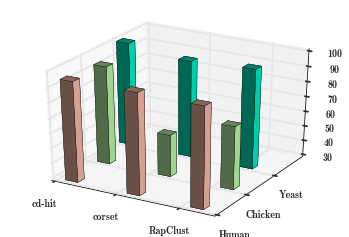

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("white")

def autolabel(rects, ax):
    for rect in rects:
    # attach some text labels
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+0.2,
                '%.2f' % float(height),
                ha='center', va='bottom', rotation=60)
N = 3
# menMeans = (2, 3, 3, 4)
# womenMeans = (91, 92, 94, 93)
yadj = 30
R = [98.99, 94.39]
K = [95.25, 58.17]
S = [36.19, 63.98]

for elem in [R, K, S]:
    elem.append( (2*elem[0]*elem[1])/(elem[0] + elem[1]) )
    
# B = [96.66, 97.45, 97.06]

# FDR = [3.41, 3.81, 3.96, 3.34]
# pre = [96.59, 	96.19, 	96.04,	96.66]
# rec = [97.50,	91.43,	91.42,	97.45]
# fdr = [3.41,	3.81,	3.96,	3.34]
# f1 =	[97.04,	93.75,	93.67,	97.06]

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
# fig,(ax2,ax1) = plt.subplots(2, 1, sharex=True)
# fig, ax2 = plt.subplots()

ax2.set_ylim([0, 3])
ax2.set_zlim([30, 100])

ax2.bar3d(ind, [2, 2, 2], [30,30,30], 0.2, 0.2, [x-30 for x in R], color='#00ceaa', label="precision")

ax2.bar3d(ind+width, [1, 1, 1], [30,30,30], 0.2, 0.2, [x-30 for x in K], color='#A1D490', label="recall")

ax2.bar3d(ind+width, [0, 0, 0], [30,30,30], 0.2, 0.2, [x-30 for x in B], color='#D4A190', label="f1")

# ax2.bar(ind, R,width, color='#90C3D4', label='Chicken')
# autolabel(ax2.bar(ind, R, width, color='#90C3D4', label='Chicken'), ax2)


# ax2.bar(ind+width, K, width, color='#C390D4', label='Human')
# autolabel(ax2.bar(ind+width, K, width, color='#C390D4', label='Human'), ax2)

# ax2.bar(ind+(2*width), S, width, color='#A1D490', label='Yeast')
# autolabel(ax2.bar(ind+(2*width), S, width, color='#A1D490', label='Yeast'), ax2)

# ax1.bar(ind+(3*width), B, width, color='#D4A190', label='Bowtie-2')
# autolabel(ax2.bar(ind+(3*width), B, width, color='#D4A190'), ax2)

# ax1.bar(3, FDR[0], width, color='#90C3D4')
# ax1.bar(3+width, FDR[1], width, color='#C390D4')
# ax1.bar(3+(2*width), FDR[2], width, color='#A1D490')
# ax1.bar(3+(3*width), FDR[3], width, color='#D4A190')

# add some
# ax2.set_ylabel('Score (%)', fontsize= 'large' )
# ax2.set_xlabel('Accuracy Measure (RapMap)', fontsize= 'large')

ax2.set_xticks(ind)
ax2.set_xticklabels( ('cd-hit', 'corset', 'RapClust') )

ax2.set_yticks(ind)
ax2.set_yticklabels( ('Human', 'Chicken', 'Yeast') )
# addBreakClips(ax2, ax1)
# ax1.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

# x0, y0 = ax2.yaxis.label.get_position()
# ax2.yaxis.set_label_coords(x0-0.08, y0+0.6)
# sns.despine()

# ax2.spines['bottom'].set_visible(False)
plt.legend(bbox_to_anchor=(1.25, 0.75))

# plt.show()
ax2.dist=12
# ax2.view_init(elev=30, azim=30)
plt.savefig('/home/avi/concordance.pdf',bbox_inches='tight', pad_inches=0)

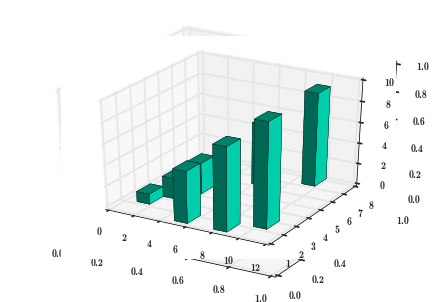

In [111]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
ax1 = fig.add_subplot(111, projection='3d')

xpos = [1,2,3,4,5,6,7,8,9,10]
ypos = [2,3,4,5,1,6,2,1,7,2]
num_elements = len(xpos)
zpos = [0,0,0,0,0,0,0,0,0,0]
dx = np.ones(10)
dy = np.ones(10)
dz = [1,2,3,4,5,6,7,8,9,10]
# ax1.view_init(elev=30, azim=45)
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color='#00ceaa')
plt.show()

In [221]:
labels = ['Q', 'S', 'K', 'B', 'Q,S', 'Q,K', 'Q,B', 'S,K', 'S,B', 'K,B', 'Q,S,K', 'Q,S,B', 'Q,K,B', 'S,K,B', 'Q,S,K,B' ]

In [233]:
val = [r1, r3, r7, r15, n12, n13, n14, n23, n24, n34, n123, n124, n134, n234, n1234]
ec = [0, 0, 0, 0] + [cap[id-4]-val[id] for id in range(4, 15)]

In [234]:
VD = pd.DataFrame(zip(labels, val, ec))

In [236]:
VD.columns = ['Method', 'Intersection', 'Bound']
VD.set_index('Method', inplace=True)

In [1]:
# sns.PairGrid(VD.T)

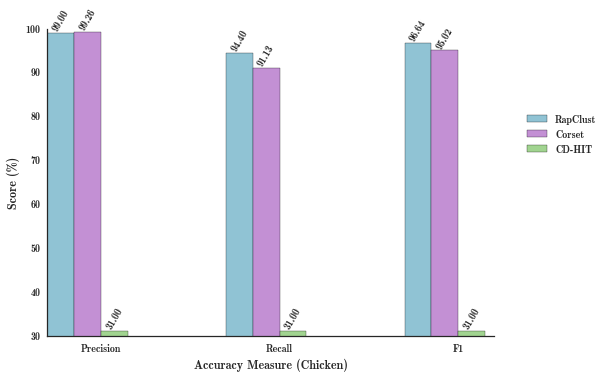

In [12]:
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("white")

def autolabel(rects, ax):
    for rect in rects:
    # attach some text labels
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+0.2,
                '%.2f' % float(height),
                ha='center', va='bottom', rotation=60)
N = 3

# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ python checkPrecRecall.py --clustfile /mnt/scratch3/avi/clustering/data/human/trinity/corset/corset-clusters.txt  --sp human --ctype corset               
# tp : 88003, fp : 3921, tn : 958292287, fn : 69442
# prec: 0.957345198207, recall: 0.55894439328
# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ python checkPrecRecall.py --clustfile /mnt/scratch3/avi/clustering/data/yeast/trinity/corset/corset-clusters.txt  --sp yeast --ctype corset               
# tp : 412, fp : 745, tn : 2037787, fn : 246
# prec: 0.356093344857, recall: 0.626139817629
# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ python checkPrecRecall.py --clustfile /mnt/scratch3/avi/clustering/data/chicken/trinity/corset/corset-clusters.txt  --sp chicken --ctype corset           
# tp : 986495, fp : 7354, tn : 2213128441, fn : 96041
# prec: 0.992600485587, recall: 0.911281472394
# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ python checkPrecRecall.py --clustfile /mnt/scratch3/avi/clustering/data/chicken/trinity/sailfish/results/mag.clust  --sp chicken                          
# tp : 1021872, fp : 10330, tn : 2213125465, fn : 60664
# prec: 0.989992268955, recall: 0.943961216994
# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ python checkPrecRecall.py --clustfile /mnt/scratch3/avi/clustering/data/human/trinity/sailfish/results/mag.clust  --sp human                              
# tp : 91522, fp : 4565, tn : 958291764, fn : 65802
# prec: 0.952490971724, recall: 0.581742137245
# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ python checkPrecRecall.py --clustfile /mnt/scratch3/avi/clustering/data/yeast/trinity/sailfish/results/mag.clust  --sp yeast                              
# tp : 421, fp : 742, tn : 2037790, fn : 237
# prec: 0.361994840929, recall: 0.639817629179
# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ vim checkPrecRecall.py 
# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ python checkPrecRecall.py --clustfile /mnt/scratch3/avi/clustering/data/yeast/trinity/cd_hit/0.8.clstr  --sp yeast --ctype cdhit                          
# tp : 239, fp : 340, tn : 2038192, fn : 419
# prec: 0.412780656304, recall: 0.363221884498
# ╭─avi@feynman  /mnt/scratch3/avi/clustering/geneModel/RapClust/src  ‹master*› 
# ╰─$ python checkPrecRecall.py --clustfile /mnt/scratch3/avi/clustering/data/human/trinity/cd_hit/0.8.clstr  --sp human --ctype cdhit                          
# tp : 58979, fp : 2607, tn : 958293601, fn : 98466
# prec: 0.957668950736, recall: 0.374600654197

#yeast
# r = [36.1994840929, 63.9817629179]
# c = [35.6093344857, 62.6139817629]
# cd = [57.2368421053, 13.2218844985]

# human
# r = [95.2490971724, 58.1742137245]
# c = [95.7345198207, 55.894439328]
# cd = [98.1511070532, 13.6555622598]

#chicken
r = [98.9992268955, 94.3961216994]
c = [99.2600485587, 91.1281472394]
cd = [99.3602266068, 7.11156422954]

for elem in [r, c, cd]:
    elem.append((2*elem[0]*elem[1])/(elem[0] + elem[1]))

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig, ax = plt.subplots()

ax.set_ylim([30, 100])

autolabel(ax.bar(ind, r, width, color='#90C3D4', label='RapClust'), ax)

autolabel(ax.bar(ind+width, c, width, color='#C390D4', label='Corset'), ax)

autolabel(ax.bar(ind+(2*width), cd, width, color='#A1D490', label='CD-HIT'), ax)


# add some
ax.set_ylabel('Score (%)', fontsize= 'large' )
ax.set_xlabel('Accuracy Measure (Chicken)', fontsize= 'large')

ax.set_xticks(ind+2*width)
ax.set_xticklabels( ('Precision', 'Recall', 'F1') )


sns.despine()

plt.legend(bbox_to_anchor=(1.25, 0.75))

# plt.show()

plt.savefig('/home/avi/concordance_chicken.pdf',bbox_inches='tight', pad_inches=0)